In [1]:
from platform import python_version

print(python_version())

3.7.5


In [156]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [157]:
path="datasets/ofg_family/"
randomiser = np.random.RandomState(123)

In [179]:
def generate_image(family_dir):
    dic={}
    sub=[a for a in listdir(path+"/"+family_dir)]
    
    for ele in sub:
        mypath = path+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((32,32),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    
    for family in families_batch:
        res = generate_image(family)
        if( res != None):
            np_images.append(res)
    
    return np_images

In [180]:
#full_data = load_npdata(path)
#print(len(full_data))

for r, d, f in os.walk(path):
        all_families=d
        break

randomiser.shuffle(all_families)

train_families = all_families[:-500]
test_families = all_families[-500:]

create encoder decoder supervised pipeling operation
input: stacked images of father and mother (32,32,6)
encoder -> decoder -> image reconstruction
reconstruction loss w/ target image as child

In [181]:
concat = tf.keras.layers.Concatenate()

family_data = generate_image(all_families[0])
inp = concat([family_data[0],family_data[1]])
child = family_data[3]
child = tf.convert_to_tensor(child, dtype=tf.float32)


In [182]:
OUTPUT_CHANNELS = 3

In [183]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [184]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [185]:
def EncoderNN():
  down_stack = [
    downsample(32, 4, apply_batchnorm=True),
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4, apply_batchnorm=False) 
  ]

  up_stack = [
    upsample(64, 4, apply_dropout=False),
    upsample(32, 4, apply_dropout=False),
    upsample(3, 4, apply_dropout=False)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[32,32,6])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
    
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [186]:
encoder = EncoderNN()

# gen_output = encoder(inp[tf.newaxis,...], training=False)
# loss= tf.reduce_mean(tf.image.total_variation(tf.concat([child,tf.squeeze(gen_output)],axis=0)))
# loss = tf.reduce_mean(tf.nn.l2_loss(child-gen_output))
# print(loss)

In [187]:
def custom_loss():
    def loss(y_true,y_pred):
        print(y_true.shape)
        print(y_pred.shape)
        return tf.reduce_mean(tf.abs(y_true - y_pred))
        #return tf.reduce_mean(tf.image.total_variation(tf.concat([y_true,y_pred],axis=0)))
    return loss

inp = concat([full_data[0][0],full_data[0][1]])
inp = tf.convert_to_tensor(inp, dtype=tf.float32)
X_train = tf.reshape(inp,([1,32,32,6]))
Y_train = tf.reshape(full_data[0][3],(1,32,32,3))

encoder.compile(loss=custom_loss(),
              optimizer=tf.keras.optimizers.RMSprop())
history = encoder.fit(X_train, Y_train,
                    batch_size=1,
                    epochs=1)

gen_output = encoder(inp[tf.newaxis,...], training=False)

In [188]:
concat = tf.keras.layers.Concatenate()

In [189]:
encoder.compile(loss=custom_loss(),optimizer=tf.keras.optimizers.RMSprop())

divide = 100
epochs = 5
batch = 20

for epoch in range(epochs):
    print("Epoch ", epoch , " .....")
    for i in range(len(train_families)//batch):
        batch_data = np.asarray(generate_batch(train_families[i*batch:(i+1)*batch]))
        
        print("Generated batch", batch_data.shape)
        
        X_train = tf.convert_to_tensor(concat([batch_data[:,0],batch_data[:,1]]),dtype =tf.float32)
        print("Batch converted to tensor")
        
        Y_train = batch_data[:,3]
        history = encoder.fit(X_train, Y_train, batch_size=batch)

(None, None, None, None)
(None, 32, 32, 3)
Epoch  0  .....
Generated batch (20, 4, 32, 32, 3)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Batch converted to tensor
Train on 20 samples
(20, 32, 32, 3)
(20, 32, 32, 3)
(20, 32, 32, 3)
(20, 32, 32, 3)
20/20 [==============================] - 1s 45ms/sample - loss: 132.9951
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 2ms/sample - loss: 125.2195
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 sampl

20/20 [==============================] - 0s 2ms/sample - loss: 119.4473
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 2ms/sample - loss: 131.3354
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 2ms/sample - loss: 130.7571
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 3ms/sample - loss: 118.9928
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 3ms/sample - loss: 116.0126
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 3ms/sample - loss: 124.1404
Generated batch (20, 4, 32, 32, 3)
Batch converted to tensor
Train on 20 samples
20/20 [==============================] - 0s 2ms/sample - loss: 128.8515
Generated 

NotADirectoryError: [Errno 20] Not a directory: 'datasets/ofg_family//F0001_1/.DS_Store/'

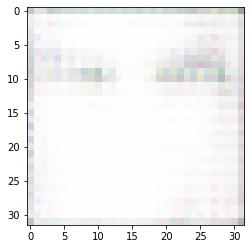

In [199]:
inp = tf.cast(inp, tf.float32)

gen_output = encoder(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])
